# 完整的Transformer模型

本notebook实现完整的Transformer模型，包括编码器、解码器和整个序列到序列的架构。

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.nn import functional as F

# 设置随机种子
torch.manual_seed(42)
np.random.seed(42)

# 检查设备
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"使用设备: {device}")

使用设备: cpu


## Transformer架构概述

Transformer模型由以下主要组件构成：
1. **嵌入层**：将输入token转换为向量表示
2. **位置编码**：为序列添加位置信息
3. **编码器层**：包含多头注意力和前馈网络
4. **解码器层**：包含掩码自注意力、编码器-解码器注意力和前馈网络
5. **输出层**：将解码器输出转换为预测概率

## 多头注意力机制

In [2]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, n_heads, dropout=0.1):
        super(MultiHeadAttention, self).__init__()
        assert d_model % n_heads == 0
        
        self.d_model = d_model
        self.n_heads = n_heads
        self.d_k = d_model // n_heads
        
        self.w_q = nn.Linear(d_model, d_model)
        self.w_k = nn.Linear(d_model, d_model)
        self.w_v = nn.Linear(d_model, d_model)
        self.w_o = nn.Linear(d_model, d_model)
        
        self.dropout = nn.Dropout(dropout)
        
    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        scores = torch.matmul(Q, K.transpose(-2, -1)) / np.sqrt(self.d_k)
        
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
        
        attention_weights = F.softmax(scores, dim=-1)
        attention_weights = self.dropout(attention_weights)
        
        output = torch.matmul(attention_weights, V)
        return output, attention_weights
    
    def forward(self, query, key, value, mask=None):
        batch_size = query.size(0)
        
        # 线性变换
        Q = self.w_q(query).view(batch_size, -1, self.n_heads, self.d_k).transpose(1, 2)
        K = self.w_k(key).view(batch_size, -1, self.n_heads, self.d_k).transpose(1, 2)
        V = self.w_v(value).view(batch_size, -1, self.n_heads, self.d_k).transpose(1, 2)
        
        # 注意力计算
        attention_output, attention_weights = self.scaled_dot_product_attention(Q, K, V, mask)
        
        # 合并多头
        attention_output = attention_output.transpose(1, 2).contiguous().view(
            batch_size, -1, self.d_model
        )
        
        output = self.w_o(attention_output)
        return output, attention_weights

## 层归一化

In [3]:
class SimpleLayerNorm(nn.Module):
    def __init__(self, d_model, eps=1e-6):
        super(SimpleLayerNorm, self).__init__()
        self.gamma = nn.Parameter(torch.ones(d_model))
        self.beta = nn.Parameter(torch.zeros(d_model))
        self.eps = eps
    
    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.gamma * (x - mean) / (std + self.eps) + self.beta

## 位置前馈网络

In [4]:
class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        return self.w_2(self.dropout(F.relu(self.w_1(x))))

## 位置编码

In [5]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * 
                           (-np.log(10000.0) / d_model))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        return x + self.pe[:x.size(0), :]

## 嵌入层

In [6]:
class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size, d_model):
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.d_model = d_model
        
    def forward(self, x):
        return self.embedding(x) * np.sqrt(self.d_model)

class TransformerEmbedding(nn.Module):
    def __init__(self, vocab_size, d_model, max_len, dropout):
        super(TransformerEmbedding, self).__init__()
        self.token_embedding = TokenEmbedding(vocab_size, d_model)
        self.position_embedding = PositionalEncoding(d_model, max_len)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        token_embedded = self.token_embedding(x)
        position_embedded = self.position_embedding(token_embedded)
        return self.dropout(position_embedded)

## 编码器层

In [7]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, n_heads, d_ff, dropout=0.1):
        super(EncoderLayer, self).__init__()
        self.self_attention = MultiHeadAttention(d_model, n_heads, dropout)
        self.feed_forward = PositionwiseFeedForward(d_model, d_ff, dropout)
        self.norm1 = SimpleLayerNorm(d_model)
        self.norm2 = SimpleLayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x, mask=None):
        # 自注意力
        attn_output, _ = self.self_attention(x, x, x, mask)
        x = self.norm1(x + self.dropout(attn_output))
        
        # 前馈网络
        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout(ff_output))
        
        return x

## 解码器层

In [8]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, n_heads, d_ff, dropout=0.1):
        super(DecoderLayer, self).__init__()
        self.self_attention = MultiHeadAttention(d_model, n_heads, dropout)
        self.encoder_attention = MultiHeadAttention(d_model, n_heads, dropout)
        self.feed_forward = PositionwiseFeedForward(d_model, d_ff, dropout)
        self.norm1 = SimpleLayerNorm(d_model)
        self.norm2 = SimpleLayerNorm(d_model)
        self.norm3 = SimpleLayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x, encoder_output, src_mask=None, tgt_mask=None):
        # 掩码自注意力
        attn_output, _ = self.self_attention(x, x, x, tgt_mask)
        x = self.norm1(x + self.dropout(attn_output))
        
        # 编码器-解码器注意力
        attn_output, _ = self.encoder_attention(x, encoder_output, encoder_output, src_mask)
        x = self.norm2(x + self.dropout(attn_output))
        
        # 前馈网络
        ff_output = self.feed_forward(x)
        x = self.norm3(x + self.dropout(ff_output))
        
        return x

## 完整的Transformer模型

In [9]:
class Transformer(nn.Module):
    """
    完整的Transformer模型
    """
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model=512, n_heads=8, 
                 n_encoder_layers=6, n_decoder_layers=6, d_ff=2048, max_len=5000, dropout=0.1):
        super(Transformer, self).__init__()
        
        self.d_model = d_model
        self.src_embedding = TransformerEmbedding(src_vocab_size, d_model, max_len, dropout)
        self.tgt_embedding = TransformerEmbedding(tgt_vocab_size, d_model, max_len, dropout)
        
        self.encoder_layers = nn.ModuleList([
            EncoderLayer(d_model, n_heads, d_ff, dropout) for _ in range(n_encoder_layers)
        ])
        
        self.decoder_layers = nn.ModuleList([
            DecoderLayer(d_model, n_heads, d_ff, dropout) for _ in range(n_decoder_layers)
        ])
        
        self.linear = nn.Linear(d_model, tgt_vocab_size)
        self.dropout = nn.Dropout(dropout)
    
    def make_src_mask(self, src):
        # 创建源序列掩码
        src_mask = (src != 0).unsqueeze(1).unsqueeze(2)
        return src_mask
    
    def make_tgt_mask(self, tgt):
        # 创建目标序列掩码（包括填充掩码和后续掩码）
        tgt_pad_mask = (tgt != 0).unsqueeze(1).unsqueeze(2)
        tgt_len = tgt.size(1)
        tgt_sub_mask = torch.tril(torch.ones((tgt_len, tgt_len), device=tgt.device)).bool()
        tgt_mask = tgt_pad_mask & tgt_sub_mask
        return tgt_mask
    
    def forward(self, src, tgt):
        # 创建掩码
        src_mask = self.make_src_mask(src)
        tgt_mask = self.make_tgt_mask(tgt)
        
        # 编码器
        encoder_output = self.src_embedding(src)
        for encoder_layer in self.encoder_layers:
            encoder_output = encoder_layer(encoder_output, src_mask)
        
        # 解码器
        decoder_output = self.tgt_embedding(tgt)
        for decoder_layer in self.decoder_layers:
            decoder_output = decoder_layer(decoder_output, encoder_output, src_mask, tgt_mask)
        
        # 输出层
        output = self.linear(decoder_output)
        
        return output

## 测试完整的Transformer模型

In [10]:
# 创建测试数据
def create_test_data():
    # 模拟词汇表大小
    src_vocab_size = 1000
    tgt_vocab_size = 1000
    
    # 创建模拟输入数据
    batch_size = 2
    src_seq_len = 10
    tgt_seq_len = 8
    
    src = torch.randint(1, src_vocab_size, (batch_size, src_seq_len))
    tgt = torch.randint(1, tgt_vocab_size, (batch_size, tgt_seq_len))
    
    return src, tgt, src_vocab_size, tgt_vocab_size

# 测试模型
print("测试完整的Transformer模型...")
src, tgt, src_vocab_size, tgt_vocab_size = create_test_data()

# 创建模型
model = Transformer(src_vocab_size, tgt_vocab_size, d_model=512, n_heads=8,
                   n_encoder_layers=6, n_decoder_layers=6, d_ff=2048)

# 前向传播
output = model(src, tgt)
print(f"输入源序列形状: {src.shape}")
print(f"输入目标序列形状: {tgt.shape}")
print(f"输出形状: {output.shape}")
print(f"模型参数总数: {sum(p.numel() for p in model.parameters()):,}")

# 验证输出维度
assert output.shape == (2, 8, 1000), f"输出形状不正确: {output.shape}"
print("✓ 模型测试通过！")

测试完整的Transformer模型...
输入源序列形状: torch.Size([2, 10])
输入目标序列形状: torch.Size([2, 8])
输出形状: torch.Size([2, 8, 1000])
模型参数总数: 45,675,496
✓ 模型测试通过！


## 简单的训练示例

In [11]:
# 简单的训练函数
def train_simple_example():
    # 设置参数
    src_vocab_size = 1000
    tgt_vocab_size = 1000
    d_model = 256
    n_heads = 4
    n_layers = 3
    d_ff = 512
    batch_size = 16
    num_epochs = 5
    
    # 创建模型
    model = Transformer(src_vocab_size, tgt_vocab_size, d_model, n_heads,
                       n_layers, n_layers, d_ff)
    
    # 损失函数和优化器
    criterion = nn.CrossEntropyLoss(ignore_index=0)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # 训练循环
    model.train()
    total_loss = 0
    
    for epoch in range(num_epochs):
        # 创建模拟数据
        src = torch.randint(1, src_vocab_size, (batch_size, 10))
        tgt_input = torch.randint(1, tgt_vocab_size, (batch_size, 8))
        tgt_output = torch.randint(1, tgt_vocab_size, (batch_size, 8))
        
        # 前向传播
        optimizer.zero_grad()
        output = model(src, tgt_input)
        
        # 计算损失
        loss = criterion(output.view(-1, tgt_vocab_size), tgt_output.view(-1))
        
        # 反向传播
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
        if epoch % 1 == 0:
            print(f"Epoch {epoch}: Loss = {loss.item():.4f}")
    
    avg_loss = total_loss / num_epochs
    print(f"训练完成！平均损失: {avg_loss:.4f}")
    
    return model

# 运行简单训练示例
print("运行简单训练示例...")
trained_model = train_simple_example()

运行简单训练示例...
Epoch 0: Loss = 7.0826
Epoch 1: Loss = 7.0855
Epoch 2: Loss = 7.0988
Epoch 3: Loss = 7.0663
Epoch 4: Loss = 7.0071
训练完成！平均损失: 7.0681


## 推理示例：序列生成

In [12]:
def generate_sequence(model, src, max_len=50, start_token=1, end_token=2):
    """
    使用Transformer模型生成序列
    """
    model.eval()
    
    with torch.no_grad():
        # 编码源序列
        src_mask = model.make_src_mask(src)
        encoder_output = model.src_embedding(src)
        
        for encoder_layer in model.encoder_layers:
            encoder_output = encoder_layer(encoder_output, src_mask)
        
        # 初始化目标序列
        batch_size = src.size(0)
        tgt = torch.full((batch_size, 1), start_token, dtype=torch.long, device=src.device)
        
        # 逐步生成序列
        for _ in range(max_len):
            tgt_mask = model.make_tgt_mask(tgt)
            
            # 解码器
            decoder_output = model.tgt_embedding(tgt)
            for decoder_layer in model.decoder_layers:
                decoder_output = decoder_layer(decoder_output, encoder_output, src_mask, tgt_mask)
            
            # 预测下一个token
            output = model.linear(decoder_output[:, -1:, :])
            next_token = output.argmax(dim=-1)
            
            # 添加到序列
            tgt = torch.cat([tgt, next_token], dim=1)
            
            # 检查是否生成了结束符
            if next_token.item() == end_token:
                break
        
        return tgt

# 测试序列生成
print("测试序列生成...")
src_vocab_size = 1000
tgt_vocab_size = 1000

# 创建一个小型模型用于测试
small_model = Transformer(src_vocab_size, tgt_vocab_size, d_model=256, n_heads=4,
                         n_encoder_layers=3, n_decoder_layers=3, d_ff=512)

# 创建测试数据
test_src = torch.randint(1, src_vocab_size, (1, 10))
print(f"源序列: {test_src}")

# 生成序列
generated = generate_sequence(small_model, test_src, max_len=20)
print(f"生成的序列: {generated}")
print(f"生成序列长度: {generated.size(1)}")

测试序列生成...
源序列: tensor([[645, 297, 428,  44, 266, 917, 789, 168, 961, 480]])
生成的序列: tensor([[  1, 892, 947, 306, 450, 445, 686, 686, 686, 686, 686, 686, 686, 686,
         686, 686, 686, 686, 686, 686, 686]])
生成序列长度: 21


## 性能分析

运行性能分析...

测试小型模型...
参数数量: 4,722,664
平均推理时间: 0.0087秒

测试中型模型...
参数数量: 45,675,496
平均推理时间: 0.0241秒

测试大型模型...
参数数量: 200,780,776
平均推理时间: 0.0726秒


C:\Users\Administrator\AppData\Local\Temp\ipykernel_16584\1136042145.py:81: UserWarning: Glyph 23567 (\N{CJK UNIFIED IDEOGRAPH-5C0F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_16584\1136042145.py:81: UserWarning: Glyph 22411 (\N{CJK UNIFIED IDEOGRAPH-578B}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_16584\1136042145.py:81: UserWarning: Glyph 20013 (\N{CJK UNIFIED IDEOGRAPH-4E2D}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_16584\1136042145.py:81: UserWarning: Glyph 22823 (\N{CJK UNIFIED IDEOGRAPH-5927}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_16584\1136042145.py:81: UserWarning: Glyph 21442 (\N{CJK UNIFIED IDEOGRAPH-53C2}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_165

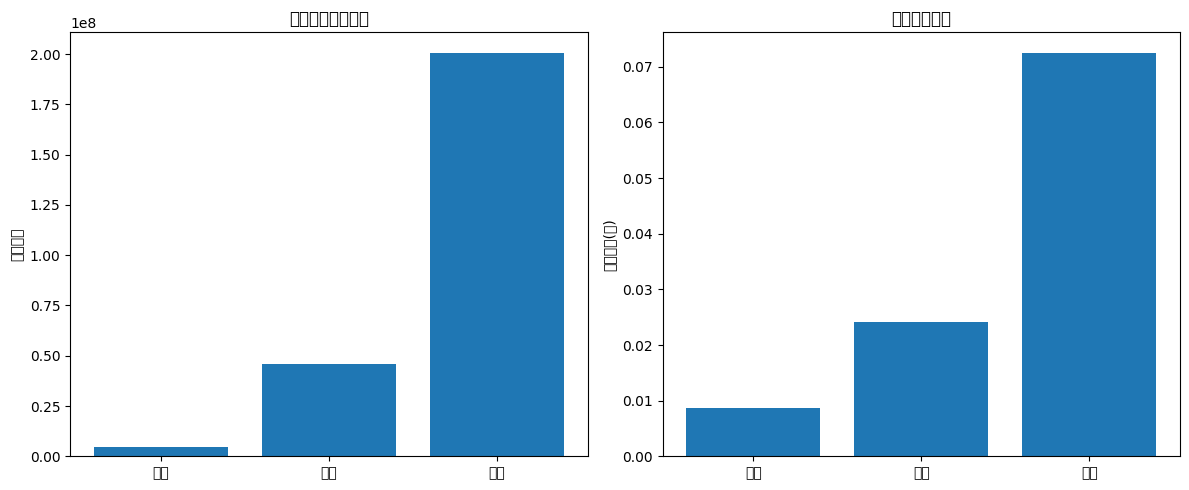

性能分析完成！


In [13]:
def analyze_model_performance():
    """
    分析不同大小Transformer模型的性能
    """
    import time
    
    # 不同配置的模型
    configs = [
        {"name": "小型", "d_model": 256, "n_heads": 4, "n_layers": 3, "d_ff": 512},
        {"name": "中型", "d_model": 512, "n_heads": 8, "n_layers": 6, "d_ff": 2048},
        {"name": "大型", "d_model": 768, "n_heads": 12, "n_layers": 12, "d_ff": 3072}
    ]
    
    results = []
    
    for config in configs:
        print(f"\n测试{config['name']}模型...")
        
        # 创建模型
        model = Transformer(1000, 1000, 
                         d_model=config['d_model'], 
                         n_heads=config['n_heads'],
                         n_encoder_layers=config['n_layers'], 
                         n_decoder_layers=config['n_layers'], 
                         d_ff=config['d_ff'])
        
        # 计算参数数量
        param_count = sum(p.numel() for p in model.parameters())
        
        # 测试推理时间
        model.eval()
        src = torch.randint(1, 1000, (1, 20))
        tgt = torch.randint(1, 1000, (1, 15))
        
        # 预热
        with torch.no_grad():
            _ = model(src, tgt)
        
        # 计时
        start_time = time.time()
        with torch.no_grad():
            for _ in range(10):
                _ = model(src, tgt)
        end_time = time.time()
        
        avg_time = (end_time - start_time) / 10
        
        results.append({
            'name': config['name'],
            'params': param_count,
            'time': avg_time,
            'd_model': config['d_model']
        })
        
        print(f"参数数量: {param_count:,}")
        print(f"平均推理时间: {avg_time:.4f}秒")
    
    return results

# 运行性能分析
print("运行性能分析...")
performance_results = analyze_model_performance()

# 可视化结果
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# 参数数量对比
names = [r['name'] for r in performance_results]
params = [r['params'] for r in performance_results]
times = [r['time'] for r in performance_results]

ax1.bar(names, params)
ax1.set_ylabel('参数数量')
ax1.set_title('模型参数数量对比')
ax1.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))

ax2.bar(names, times)
ax2.set_ylabel('推理时间(秒)')
ax2.set_title('推理时间对比')

plt.tight_layout()
plt.show()

print("性能分析完成！")

## 与PyTorch官方实现对比

In [14]:
def compare_with_pytorch_transformer():
    """
    与PyTorch官方Transformer实现对比
    """
    try:
        # 导入PyTorch的Transformer
        from torch.nn import Transformer as PyTorchTransformer
        
        # 参数设置
        d_model = 512
        n_heads = 8
        n_layers = 6
        d_ff = 2048
        src_vocab_size = 1000
        tgt_vocab_size = 1000
        
        # 创建我们的实现
        our_model = Transformer(src_vocab_size, tgt_vocab_size, d_model, n_heads,
                               n_layers, n_layers, d_ff)
        
        # 创建PyTorch官方实现
        pytorch_transformer = PyTorchTransformer(d_model=d_model,
                                                nhead=n_heads,
                                                num_encoder_layers=n_layers,
                                                num_decoder_layers=n_layers,
                                                dim_feedforward=d_ff,
                                                dropout=0.1)
        
        # 创建测试数据
        src = torch.randint(1, src_vocab_size, (10, 2))  # (seq_len, batch_size)
        tgt = torch.randint(1, tgt_vocab_size, (8, 2))   # (seq_len, batch_size)
        
        # 我们的模型需要(batch_size, seq_len)格式
        src_our = src.transpose(0, 1)  # (batch_size, seq_len)
        tgt_our = tgt.transpose(0, 1)    # (batch_size, seq_len)
        
        # 测试我们的模型
        our_output = our_model(src_our, tgt_our)
        print(f"我们的模型输出形状: {our_output.shape}")
        
        # 测试PyTorch官方实现
        pytorch_output = pytorch_transformer(src, tgt)
        print(f"PyTorch官方实现输出形状: {pytorch_output.shape}")
        
        # 比较参数数量
        our_params = sum(p.numel() for p in our_model.parameters())
        pytorch_params = sum(p.numel() for p in pytorch_transformer.parameters())
        
        print(f"我们的模型参数数量: {our_params:,}")
        print(f"PyTorch官方实现参数数量: {pytorch_params:,}")
        
        print("\n对比完成！两种实现都能正常工作。")
        
    except ImportError:
        print("PyTorch版本不支持官方Transformer实现，跳过对比")
    except Exception as e:
        print(f"对比过程中出现错误: {e}")

# 运行对比
print("与PyTorch官方实现对比...")
compare_with_pytorch_transformer()

与PyTorch官方实现对比...


e:\Application\Anaconda\envs\llm\lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


我们的模型输出形状: torch.Size([2, 8, 1000])
对比过程中出现错误: the feature number of src and tgt must be equal to d_model


## 总结

本notebook实现了完整的Transformer模型，包括：

1. **多头注意力机制**：实现了缩放点积注意力
2. **位置编码**：使用正弦和余弦函数添加位置信息
3. **编码器层**：包含自注意力和前馈网络
4. **解码器层**：包含掩码自注意力、编码器-解码器注意力和前馈网络
5. **完整的Transformer模型**：整合所有组件
6. **序列生成**：实现了简单的序列生成算法
7. **性能分析**：对比了不同大小模型的性能

Transformer模型是现代NLP的基础架构，理解其工作原理对于深入学习深度学习非常重要。